In [14]:
# Analysis of Experimental Mouse Brain Data Courtesy of Marija. 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pylab
import matplotlib.pyplot as plt
from scipy import stats
import inspect
import os
import csv 
import time

from tvb.simulator.lab import *
from tvb.simulator.plot.tools import *

# Load .mat file containing the Time series data.  Is a 169 x 900 x 100 Matrix.  Num brian regions x Num samples recorinding x num mice
# https://towardsdatascience.com/how-to-load-matlab-mat-files-in-python-1f200e1287b5 
from scipy.io import loadmat
annots = loadmat('E:\Documents\Work\\Year 5 Honours - 2020\\timeSeriesData.mat') 
DataMatrix = annots['timeSeriesData']

'''
# Import StructInfo - Gives error for now, likely due to depracation of Python 2
StructInfo = pd.read_excel (r'E:\Documents\Work\structInfo_Oh_169.xlsx')
'''
# Verify shape.
DataMatrix.shape

(169, 900, 100)

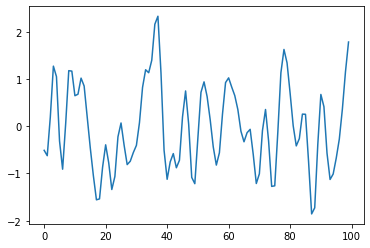

In [9]:
# Have a Look at Region 38, Mouse 0
plt.plot(DataMatrix[37,:100,0])

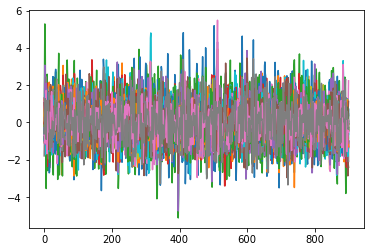

In [4]:
for i in np.arange(38):
    plt.plot(DataMatrix[i,:,0])    

In [5]:
# What needs to happen is to obtain each matrix (100 total for the no. of mice)

# Create empty 3D Matrix to hold FC analysis
FCMatrix = np.empty((38,38,100))

for i in range(100):
    # For now we only take the cortical areas, so the first 38 rows.
    run = DataMatrix[0:38,:,i]

    # np.size(DataMatrix[:,:,0]) # Verify correct. 

    # Run Analysis - Pearson Correlation.
    FCM = np.corrcoef(run)
    FCMatrix[:,:,i] = FCM

# Average over the 100 mice. 
FCAverage = FCMatrix.mean(2)

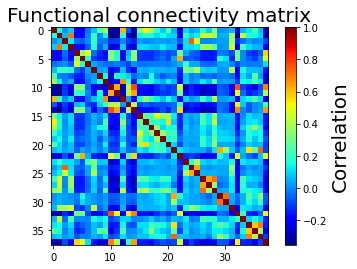

In [6]:
# Plot Matrix
# For Individual slice of FC Matrix: FCMatrix[:,:,0]

cs=plt.imshow(FCAverage, cmap='jet', aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)

In [7]:
# Write Code to export the simulation to csv.
np.savetxt("do-not-track\FCM_MouseExperimental.csv", FCAverage, delimiter="\t")

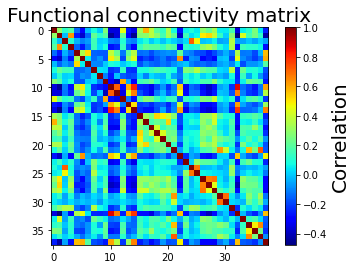

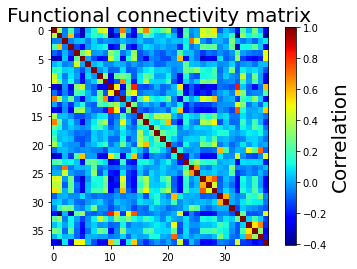

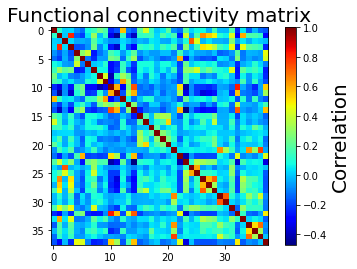

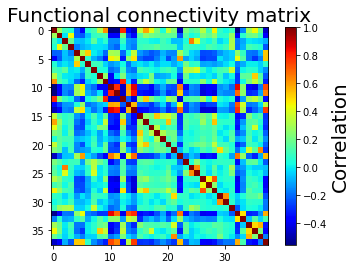

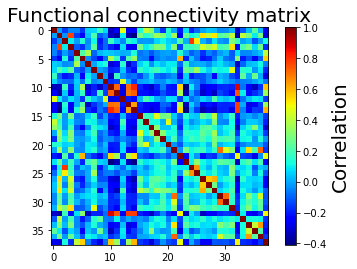

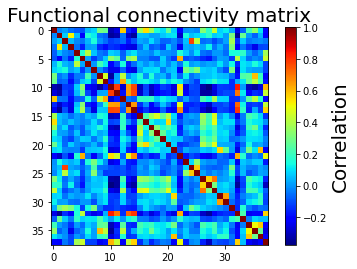

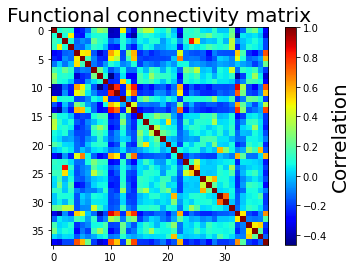

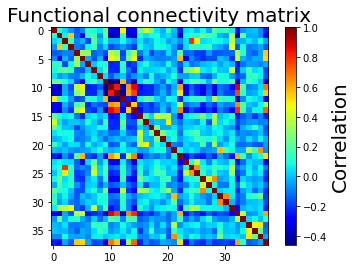

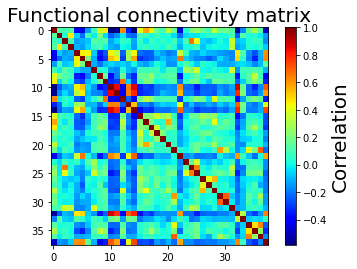

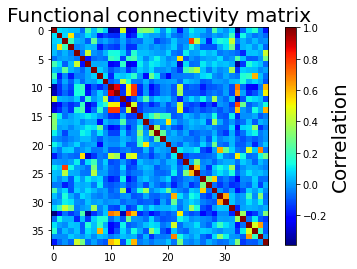

In [8]:
# Plot the FC Matrices for Each mouse as a check. 

for i in range(10):
    plt.figure()
    cs=plt.imshow(FCMatrix[:,:,i], cmap='jet', aspect='equal', interpolation='none')
    plt.title('Functional connectivity matrix', fontsize=20)
    axcb=plt.colorbar(cs)
    axcb.set_label('Correlation', fontsize=20)# Sanity s\check seems good.

## Calculate Baseline SC-FC 


In [15]:
# Empty dict
ParamsDict = { }
ParamsDict["name"] = "MouseCortex"
#ParamsDict["G"] = np.array([G_value]) 
ParamsDict["REMOVE"] = [7]
ParamsDict["BINARY"]=True

# Load the connectivity data from a zip file. 
con = connectivity.Connectivity.from_file(os.getcwd() +"/Connectomes/" + ParamsDict["name"] + ".zip")

# Remove the ith row and column in centres, tract_lengths and weights. i.e. the specified region(s)
con.centres = np.delete(con.centres,ParamsDict["REMOVE"])
con.weights = np.delete(con.weights,obj=ParamsDict["REMOVE"],axis=0)
con.weights = np.delete(con.weights,obj=ParamsDict["REMOVE"],axis=1)
con.tract_lengths = np.delete(con.tract_lengths,obj=ParamsDict["REMOVE"],axis=0)
con.tract_lengths = np.delete(con.tract_lengths,obj=ParamsDict["REMOVE"],axis=1)

if ParamsDict["BINARY"]==True:
    con.weights = con.weights!=0
SCM = con.weights

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


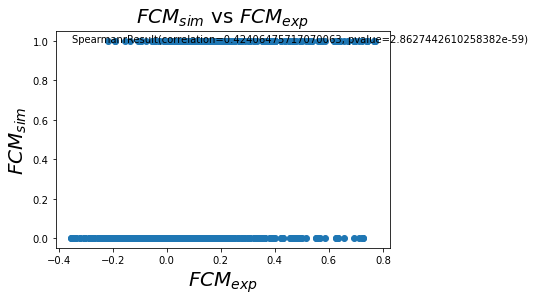

In [21]:
FCM_exp = np.genfromtxt('FCM_MouseExperimental.csv',delimiter = "\t")
# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)

# Remove the ith row and column in FCM (i.e. the specified region)
FCM_exp = np.delete(FCM_exp,obj=ParamsDict["REMOVE"],axis=0)
FCM_exp = np.delete(FCM_exp,obj=ParamsDict["REMOVE"],axis=1)

np.fill_diagonal(SCM,np.nan)
# Remove all Nans for SCM and FCM
SCM_Upper = SCM[~numpy.isnan(SCM)]
FCM_Upper = FCM_exp[~numpy.isnan(FCM_exp)]


# Spearman Correlation
Scorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
#print(SCorr)

# Scatterplot
plt.scatter(FCM_Upper,SCM_Upper)
plt.xlabel('$FCM_{exp}$', fontsize=20)
plt.ylabel('$FCM_{sim}$', fontsize=20)
plt.title('$FCM_{sim}$ vs $FCM_{exp}$', fontsize=20)
plt.annotate(Scorr, xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()